In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import confusion_matrix, accuracy_score,  ConfusionMatrixDisplay, classification_report
import seaborn as sns

from sklearn.model_selection import train_test_split
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:

transform = transforms.Compose([
    transforms.ToTensor(), # this converts the image to pixel values rangin from 0 to 1
    transforms.Normalize((0.1307,), (0.3081,)) # Normalizing to reach 0 and 1 mean and standard deviation respectively
])

The mean and standard deviation values of 0.1307 and 0.3081 are specific to the MNIST dataset. They are calculated based on the pixel values of the entire dataset. Using these specific values helps in standardizing the dataset to have a mean of 0 and a standard deviation of 1 after normalization.  If we were to use 0 and 1 directly, it would not standardize the dataset correctly because the original pixel values of the MNIST dataset do not have a mean of 0 and a standard deviation of 1. The normalization process using 0.1307 and 0.3081 ensures that the data is centered and scaled appropriately for better training performance.

# Loading the MNIST train and test dataset


In [4]:
train_dataset = torchvision.datasets.MNIST(root='./DATA_MNIST', train=True, transform=transform, download=False)
test_dataset = torchvision.datasets.MNIST(root='./DATA_MNIST', train=False, transform=transform, download=False)


# Stratified splitting the training data into Train/Validation

In [5]:

train_indices, val_indices, _, _ = train_test_split(
    list(range(len(train_dataset))), train_dataset.targets.numpy(), test_size=1/6, stratify=train_dataset.targets.numpy(), random_state=42
)
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)

print(len(train_subset))
print(len(val_subset))
print(len(test_dataset))

50000
10000
10000


# Loading the MNIST train and test datasets

In [6]:
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Visualizing our data

In [7]:
(images, labels) = next(iter(train_loader))
print(images.shape) # 64 batch size, 1 channel, 28x28 features
print(labels.shape) # 64 labels

torch.Size([32, 1, 28, 28])
torch.Size([32])


# Neural Network Architecture

In [43]:
import torch.nn as nn

class FeedforwardNN(nn.Module):
    def __init__(self, layer_configs):
        """
        Initializes the Feedforward Neural Network.

        Args:
            layer_configs (list): A list where each element specifies the number of neurons 
                                  in a layer. The first element is the input size, the last 
                                  element is the output size, and elements in between are
                                  hidden layers.
        """
        super(FeedforwardNN, self).__init__()

        # Store layer configurations
        self.layer_configs = layer_configs

        # Dynamically create layers based on layer_configs
        layers = []
        for i in range(len(layer_configs) - 1):
            layers.append(nn.Linear(layer_configs[i], layer_configs[i + 1]))
            if i < len(layer_configs) - 2:  # Add ReLU activation only for hidden layers
                layers.append(nn.ReLU())
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # Flatten the input based on the input layer size
        x = x.view(-1, self.layer_configs[0])
        return self.model(x)


# Example Configuration for the model

In [44]:
layer_configs = [28 * 28, 128, 64, 10]  
model = FeedforwardNN(layer_configs).to(device)
print(model)

FeedforwardNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)


# Visualizing a sample of the data


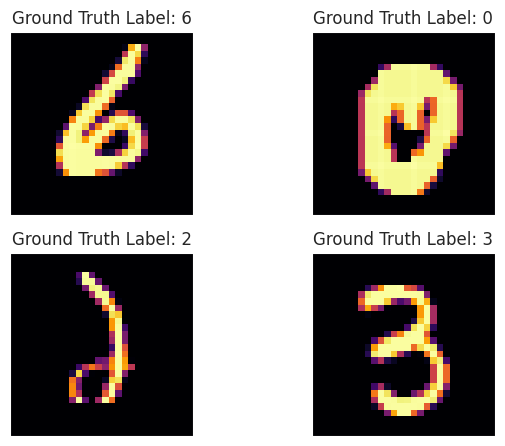

In [10]:
fig = plt.figure()
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.tight_layout()
    plt.imshow(images[i][0], cmap='inferno')
    plt.title("Ground Truth Label: {}".format(labels[i]))
    plt.yticks([])
    plt.xticks([])
plt.show()

# Method for training Model


In [11]:
import torch.optim as optim

def train_model(model, train_loader, val_loader, learning_rate, epochs=10):
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    # Initialize lists to store the loss and accuracy values
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []  # Correct initialization

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to device
            optimizer.zero_grad()  # Zero the gradients

            # Forward pass
            outputs = model(inputs)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            # Calculate accuracy for the training set
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        epoch_train_loss = running_loss / total_train
        epoch_train_accuracy = correct_train / total_train
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_running_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to device
                outputs = model(inputs)
                loss = nn.CrossEntropyLoss()(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)

                # Calculate accuracy for the validation set
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        epoch_val_loss = val_running_loss / total_val
        epoch_val_accuracy = correct_val / total_val
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)

        # Print progress for each epoch
        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies


# Plotting validation and trainging accuracies


In [12]:
import matplotlib.pyplot as plt

def plot_results(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Analyzing Different learning rates



Training with Learning Rate = 0.001
Epoch [1/10], Train Loss: 1.9953, Train Accuracy: 0.4300, Val Loss: 1.5069, Val Accuracy: 0.6885
Epoch [2/10], Train Loss: 1.0150, Train Accuracy: 0.7820, Val Loss: 0.7024, Val Accuracy: 0.8306
Epoch [3/10], Train Loss: 0.5776, Train Accuracy: 0.8546, Val Loss: 0.4998, Val Accuracy: 0.8716
Epoch [4/10], Train Loss: 0.4505, Train Accuracy: 0.8777, Val Loss: 0.4203, Val Accuracy: 0.8839
Epoch [5/10], Train Loss: 0.3922, Train Accuracy: 0.8898, Val Loss: 0.3776, Val Accuracy: 0.8950
Epoch [6/10], Train Loss: 0.3582, Train Accuracy: 0.8979, Val Loss: 0.3510, Val Accuracy: 0.9013
Epoch [7/10], Train Loss: 0.3352, Train Accuracy: 0.9032, Val Loss: 0.3318, Val Accuracy: 0.9081
Epoch [8/10], Train Loss: 0.3180, Train Accuracy: 0.9075, Val Loss: 0.3174, Val Accuracy: 0.9123
Epoch [9/10], Train Loss: 0.3041, Train Accuracy: 0.9111, Val Loss: 0.3067, Val Accuracy: 0.9126
Epoch [10/10], Train Loss: 0.2924, Train Accuracy: 0.9150, Val Loss: 0.2958, Val Accuracy:

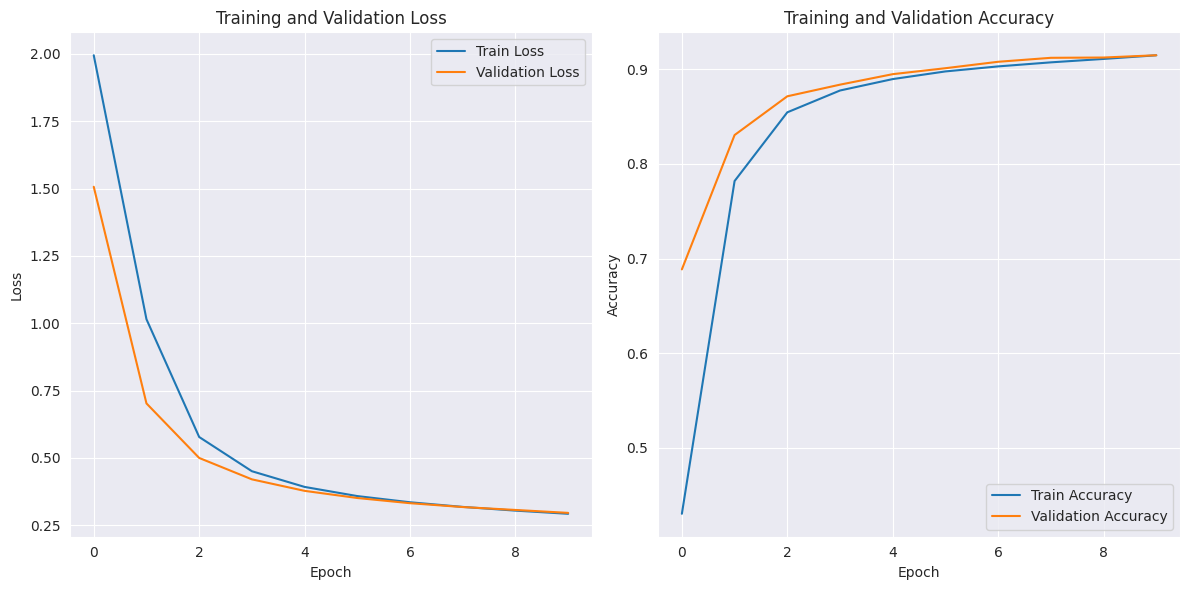


Training with Learning Rate = 0.01
Epoch [1/10], Train Loss: 0.6135, Train Accuracy: 0.8363, Val Loss: 0.3167, Val Accuracy: 0.9076
Epoch [2/10], Train Loss: 0.2612, Train Accuracy: 0.9227, Val Loss: 0.2406, Val Accuracy: 0.9305
Epoch [3/10], Train Loss: 0.2029, Train Accuracy: 0.9409, Val Loss: 0.1938, Val Accuracy: 0.9440
Epoch [4/10], Train Loss: 0.1648, Train Accuracy: 0.9524, Val Loss: 0.1668, Val Accuracy: 0.9534
Epoch [5/10], Train Loss: 0.1383, Train Accuracy: 0.9590, Val Loss: 0.1484, Val Accuracy: 0.9584
Epoch [6/10], Train Loss: 0.1188, Train Accuracy: 0.9650, Val Loss: 0.1375, Val Accuracy: 0.9601
Epoch [7/10], Train Loss: 0.1031, Train Accuracy: 0.9700, Val Loss: 0.1222, Val Accuracy: 0.9644
Epoch [8/10], Train Loss: 0.0904, Train Accuracy: 0.9730, Val Loss: 0.1192, Val Accuracy: 0.9648
Epoch [9/10], Train Loss: 0.0802, Train Accuracy: 0.9768, Val Loss: 0.1152, Val Accuracy: 0.9652
Epoch [10/10], Train Loss: 0.0716, Train Accuracy: 0.9793, Val Loss: 0.1049, Val Accuracy: 

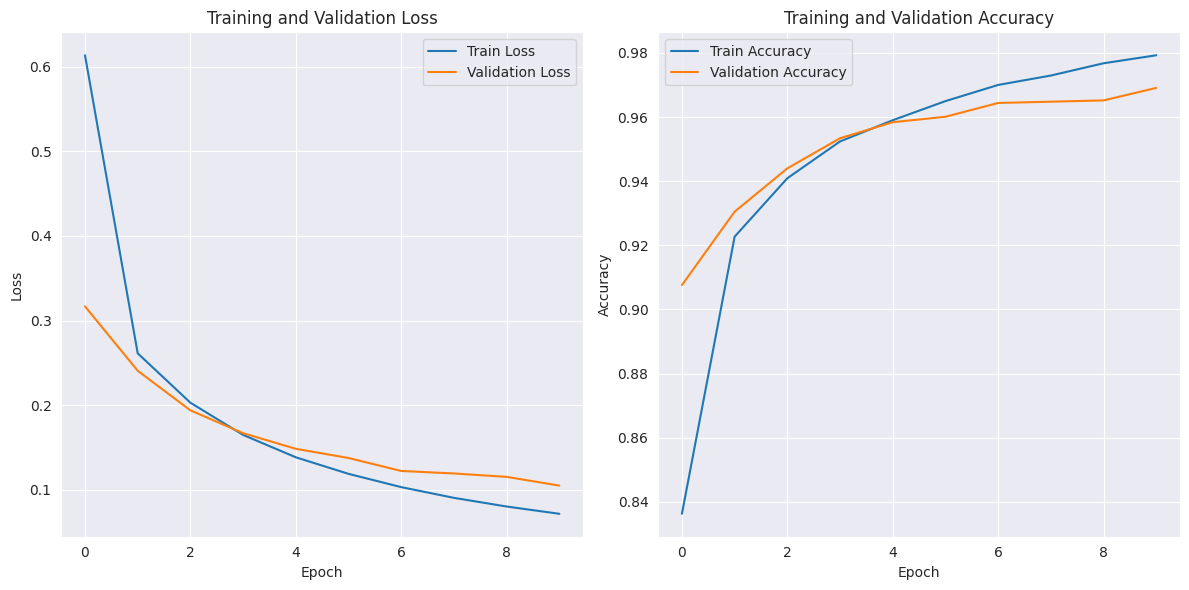


Training with Learning Rate = 0.1
Epoch [1/10], Train Loss: 0.2591, Train Accuracy: 0.9192, Val Loss: 0.1919, Val Accuracy: 0.9404
Epoch [2/10], Train Loss: 0.1028, Train Accuracy: 0.9680, Val Loss: 0.1150, Val Accuracy: 0.9662
Epoch [3/10], Train Loss: 0.0723, Train Accuracy: 0.9774, Val Loss: 0.1376, Val Accuracy: 0.9577
Epoch [4/10], Train Loss: 0.0518, Train Accuracy: 0.9828, Val Loss: 0.0914, Val Accuracy: 0.9729
Epoch [5/10], Train Loss: 0.0388, Train Accuracy: 0.9875, Val Loss: 0.0926, Val Accuracy: 0.9732
Epoch [6/10], Train Loss: 0.0314, Train Accuracy: 0.9902, Val Loss: 0.0934, Val Accuracy: 0.9736
Epoch [7/10], Train Loss: 0.0277, Train Accuracy: 0.9903, Val Loss: 0.0946, Val Accuracy: 0.9752
Epoch [8/10], Train Loss: 0.0177, Train Accuracy: 0.9944, Val Loss: 0.1082, Val Accuracy: 0.9742
Epoch [9/10], Train Loss: 0.0174, Train Accuracy: 0.9942, Val Loss: 0.1115, Val Accuracy: 0.9709
Epoch [10/10], Train Loss: 0.0100, Train Accuracy: 0.9968, Val Loss: 0.0942, Val Accuracy: 0

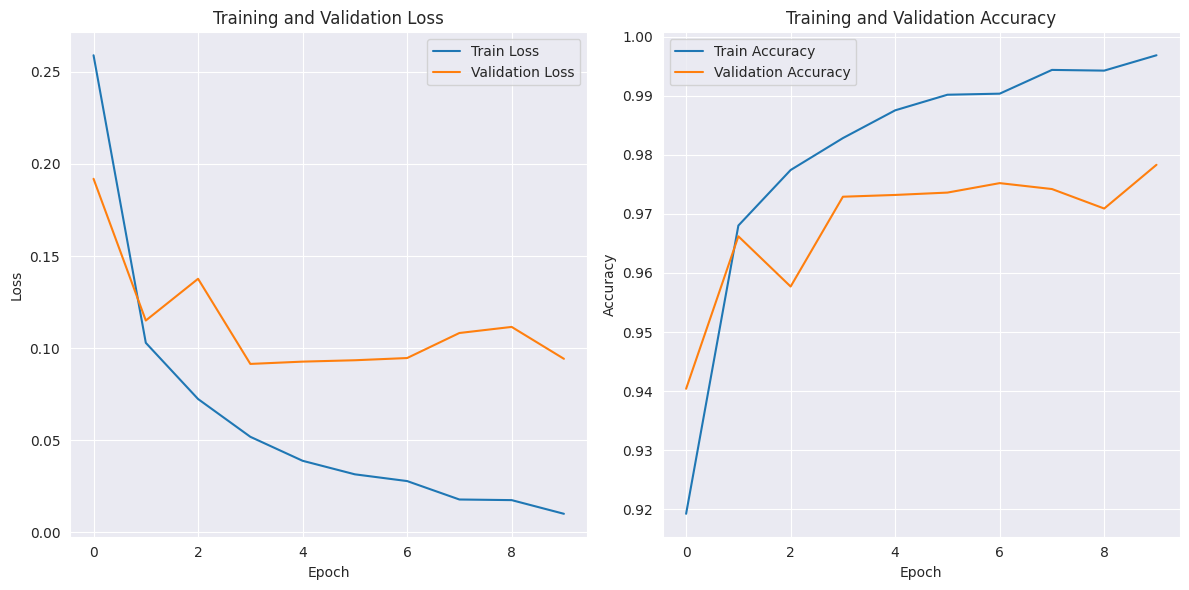


Training with Learning Rate = 0.5
Epoch [1/10], Train Loss: 0.5042, Train Accuracy: 0.8584, Val Loss: 0.2866, Val Accuracy: 0.9268
Epoch [2/10], Train Loss: 0.2861, Train Accuracy: 0.9286, Val Loss: 0.2388, Val Accuracy: 0.9415
Epoch [3/10], Train Loss: 0.2362, Train Accuracy: 0.9406, Val Loss: 0.3382, Val Accuracy: 0.9121
Epoch [4/10], Train Loss: 0.2519, Train Accuracy: 0.9406, Val Loss: 0.2244, Val Accuracy: 0.9520
Epoch [5/10], Train Loss: 0.2061, Train Accuracy: 0.9518, Val Loss: 0.3752, Val Accuracy: 0.9170
Epoch [6/10], Train Loss: 0.2295, Train Accuracy: 0.9493, Val Loss: 0.2380, Val Accuracy: 0.9449
Epoch [7/10], Train Loss: 0.2063, Train Accuracy: 0.9531, Val Loss: 0.6585, Val Accuracy: 0.9217
Epoch [8/10], Train Loss: 0.1987, Train Accuracy: 0.9564, Val Loss: 0.2488, Val Accuracy: 0.9514
Epoch [9/10], Train Loss: 0.2031, Train Accuracy: 0.9572, Val Loss: 0.3115, Val Accuracy: 0.9471
Epoch [10/10], Train Loss: 0.2072, Train Accuracy: 0.9553, Val Loss: 0.3119, Val Accuracy: 0

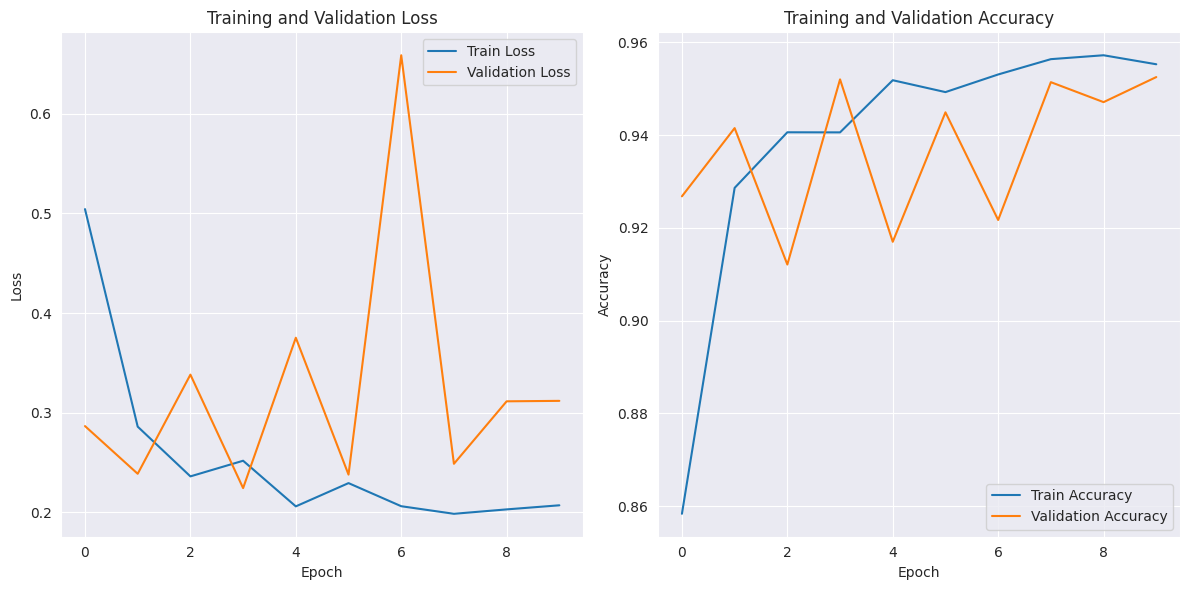

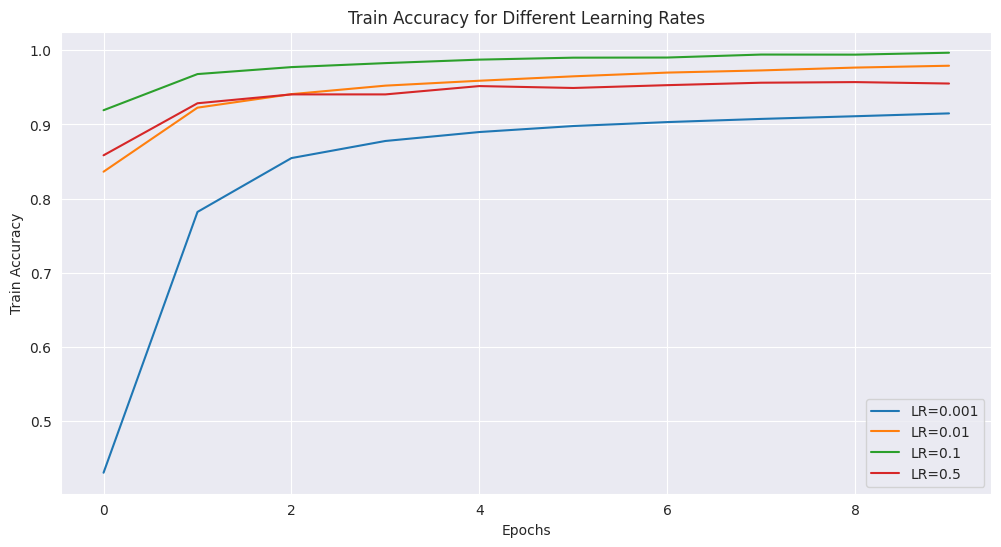

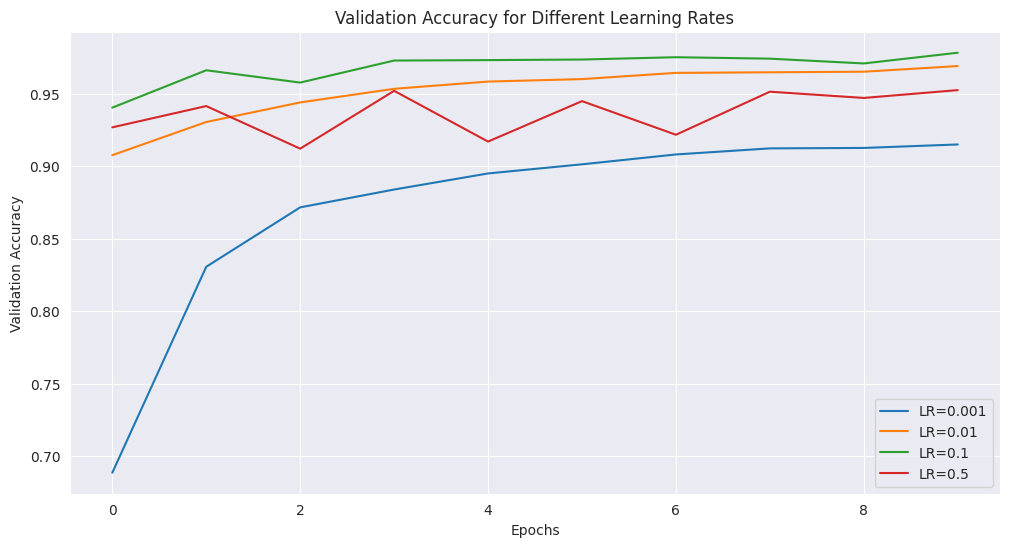

In [13]:
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

learning_rates = [0.001, 0.01, 0.1, 0.5]  # Different learning rates to experiment with

# Store results for each learning rate
results = {}

for lr in learning_rates:
    model = FeedforwardNN([28*28,128,64,10]).to(device)  # Initialize model
    print(f"\nTraining with Learning Rate = {lr}")
    # Train the model with the current learning rate
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, lr)
    
    # Store the results
    results[lr] = {
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }
    
    # Plot results after each experiment
    plot_results(train_losses, val_losses, train_accuracies, val_accuracies)

# Plot all learning rates on the same plot for train accuracies
plt.figure(figsize=(12, 6))
for lr in learning_rates:
    plt.plot(results[lr]['train_accuracies'], label=f"LR={lr}")
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy for Different Learning Rates")
plt.legend()
plt.show()

# Plot all learning rates on the same plot for validation accuracies
plt.figure(figsize=(12, 6))
for lr in learning_rates:
    plt.plot(results[lr]['val_accuracies'], label=f"LR={lr}")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy for Different Learning Rates")
plt.legend()
plt.show()

## Key Insights

### Learning Rate = 0.0001
- **Training Speed:** Slow convergence with gradual improvement.
- **Final Results:** 
  - Training Accuracy: 56.52% 
  - Validation Accuracy: 57.16%
- **Comment:** The learning rate is too low, resulting in underfitting and slow progress.

---

### Learning Rate = 0.001
- **Training Speed:** Faster convergence with significant accuracy improvements by epoch 10.
- **Final Results:** 
  - Training Accuracy: 90.51% 
  - Validation Accuracy: 90.31%
- **Comment:** A good balance between convergence speed and accuracy.

---

### Learning Rate = 0.007
- **Training Speed:** Rapid improvement, with training and validation accuracy surpassing 94% by epoch 10.
- **Final Results:** 
  - Training Accuracy: 96.91% 
  - Validation Accuracy: 96.10%
- **Comment:** Performs well, maintaining stability throughout training.

---

### Learning Rate = 0.01
- **Training Speed:** Excellent convergence rate, reaching over 95% accuracy by epoch 10.
- **Final Results:** 
  - Training Accuracy: 98.03% 
  - Validation Accuracy: 96.84%
- **Comment:** Balances fast convergence with excellent performance, though slight overfitting may occur.

---

### Learning Rate = 0.1
- **Training Speed:** Extremely fast convergence, achieving near-perfect training accuracy within 10 epochs.
- **Final Results:** 
  - Training Accuracy: 100% 
  - Validation Accuracy: 98.23%
- **Comment:** High learning rate may lead to overfitting, as evidenced by the gap between training and validation metrics.

---

### Learning Rate = 0.5
- **Training Speed:** Very fast convergence, with near-optimal accuracy by epoch 10.
- **Final Results:** 
  - Training Accuracy: 99.53% 
  - Validation Accuracy: 97.80%
- **Comment:** Extremely high learning rate risks overshooting and overfitting.

---

## Best Learning Rate
- **0.01** is the best choice:
  - Excellent accuracy: 
    - Training: 98.03% 
    - Validation: 96.84%
  - Balances fast convergence and stability.
  - Demonstrates minimal overfitting compared to higher learning rates.

- **Alternative:** 
  - **0.007** is a strong contender for slightly slower but more stable progress.


# Analyzing different batch sizes



Training with Batch Size = 16
Epoch [1/15], Train Loss: 0.4515, Train Accuracy: 0.8723, Val Loss: 0.2307, Val Accuracy: 0.9337
Epoch [2/15], Train Loss: 0.1894, Train Accuracy: 0.9433, Val Loss: 0.1730, Val Accuracy: 0.9479
Epoch [3/15], Train Loss: 0.1339, Train Accuracy: 0.9602, Val Loss: 0.1337, Val Accuracy: 0.9608
Epoch [4/15], Train Loss: 0.1032, Train Accuracy: 0.9695, Val Loss: 0.1177, Val Accuracy: 0.9659
Epoch [5/15], Train Loss: 0.0828, Train Accuracy: 0.9762, Val Loss: 0.1054, Val Accuracy: 0.9681
Epoch [6/15], Train Loss: 0.0686, Train Accuracy: 0.9801, Val Loss: 0.0985, Val Accuracy: 0.9703
Epoch [7/15], Train Loss: 0.0575, Train Accuracy: 0.9828, Val Loss: 0.0928, Val Accuracy: 0.9722
Epoch [8/15], Train Loss: 0.0486, Train Accuracy: 0.9856, Val Loss: 0.0884, Val Accuracy: 0.9747
Epoch [9/15], Train Loss: 0.0404, Train Accuracy: 0.9888, Val Loss: 0.0906, Val Accuracy: 0.9740
Epoch [10/15], Train Loss: 0.0347, Train Accuracy: 0.9900, Val Loss: 0.0874, Val Accuracy: 0.975

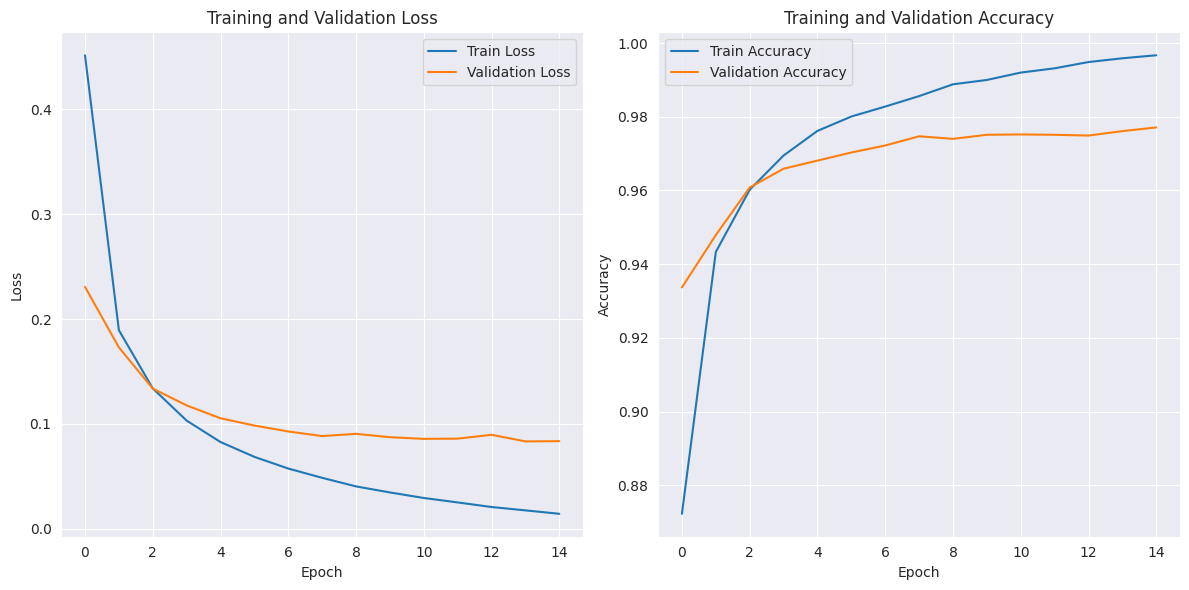


Training with Batch Size = 32
Epoch [1/15], Train Loss: 0.6537, Train Accuracy: 0.8229, Val Loss: 0.3244, Val Accuracy: 0.9014
Epoch [2/15], Train Loss: 0.2726, Train Accuracy: 0.9201, Val Loss: 0.2542, Val Accuracy: 0.9238
Epoch [3/15], Train Loss: 0.2125, Train Accuracy: 0.9384, Val Loss: 0.1968, Val Accuracy: 0.9441
Epoch [4/15], Train Loss: 0.1710, Train Accuracy: 0.9507, Val Loss: 0.1798, Val Accuracy: 0.9468
Epoch [5/15], Train Loss: 0.1431, Train Accuracy: 0.9583, Val Loss: 0.1503, Val Accuracy: 0.9548
Epoch [6/15], Train Loss: 0.1219, Train Accuracy: 0.9647, Val Loss: 0.1385, Val Accuracy: 0.9597
Epoch [7/15], Train Loss: 0.1060, Train Accuracy: 0.9694, Val Loss: 0.1286, Val Accuracy: 0.9617
Epoch [8/15], Train Loss: 0.0932, Train Accuracy: 0.9732, Val Loss: 0.1189, Val Accuracy: 0.9650
Epoch [9/15], Train Loss: 0.0827, Train Accuracy: 0.9760, Val Loss: 0.1113, Val Accuracy: 0.9659
Epoch [10/15], Train Loss: 0.0735, Train Accuracy: 0.9785, Val Loss: 0.1049, Val Accuracy: 0.968

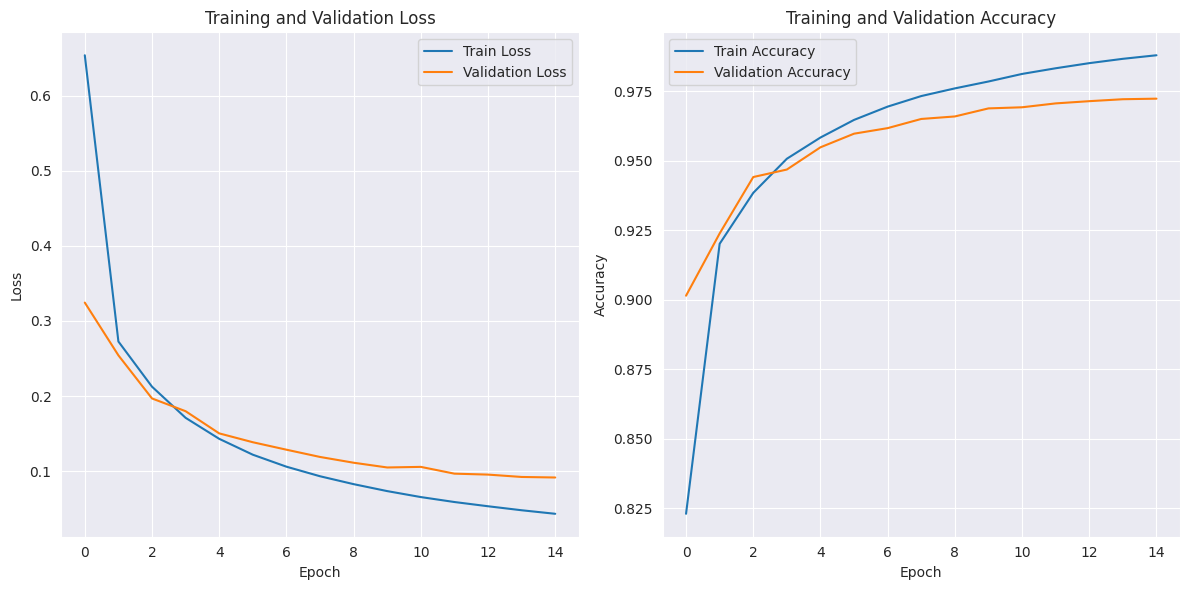


Training with Batch Size = 64
Epoch [1/15], Train Loss: 0.9494, Train Accuracy: 0.7556, Val Loss: 0.4070, Val Accuracy: 0.8817
Epoch [2/15], Train Loss: 0.3365, Train Accuracy: 0.9042, Val Loss: 0.3163, Val Accuracy: 0.9095
Epoch [3/15], Train Loss: 0.2776, Train Accuracy: 0.9193, Val Loss: 0.2722, Val Accuracy: 0.9206
Epoch [4/15], Train Loss: 0.2414, Train Accuracy: 0.9298, Val Loss: 0.2382, Val Accuracy: 0.9321
Epoch [5/15], Train Loss: 0.2122, Train Accuracy: 0.9388, Val Loss: 0.2154, Val Accuracy: 0.9381
Epoch [6/15], Train Loss: 0.1890, Train Accuracy: 0.9455, Val Loss: 0.1986, Val Accuracy: 0.9420
Epoch [7/15], Train Loss: 0.1695, Train Accuracy: 0.9509, Val Loss: 0.1792, Val Accuracy: 0.9483
Epoch [8/15], Train Loss: 0.1526, Train Accuracy: 0.9560, Val Loss: 0.1682, Val Accuracy: 0.9518
Epoch [9/15], Train Loss: 0.1384, Train Accuracy: 0.9595, Val Loss: 0.1560, Val Accuracy: 0.9549
Epoch [10/15], Train Loss: 0.1262, Train Accuracy: 0.9634, Val Loss: 0.1537, Val Accuracy: 0.955

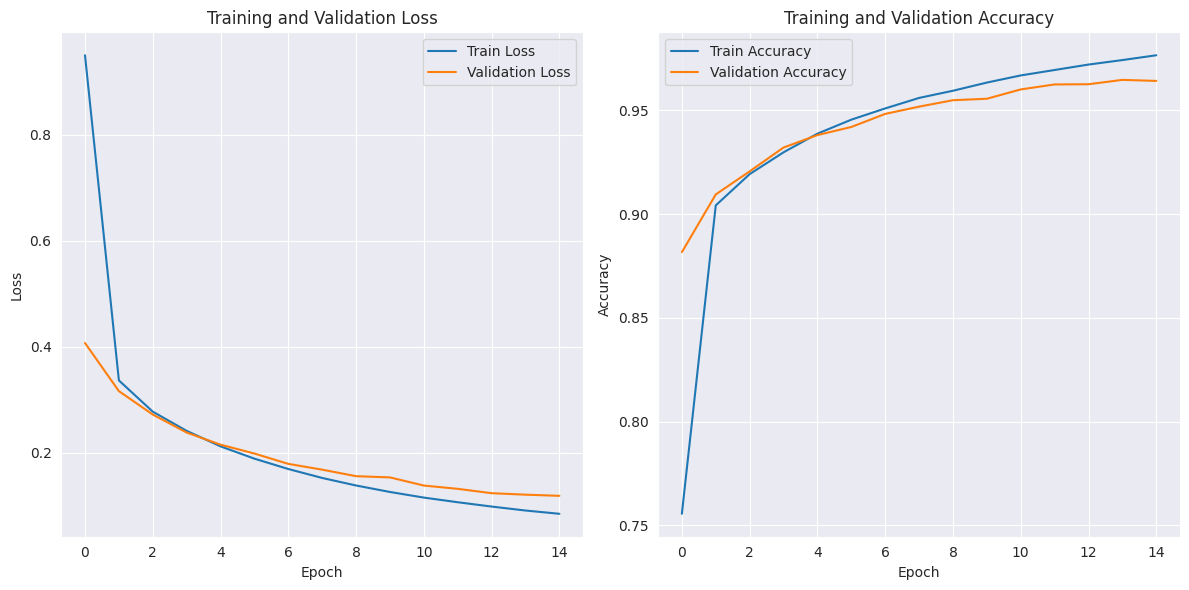


Training with Batch Size = 128
Epoch [1/15], Train Loss: 1.3182, Train Accuracy: 0.6663, Val Loss: 0.5740, Val Accuracy: 0.8539
Epoch [2/15], Train Loss: 0.4544, Train Accuracy: 0.8768, Val Loss: 0.3875, Val Accuracy: 0.8928
Epoch [3/15], Train Loss: 0.3528, Train Accuracy: 0.8980, Val Loss: 0.3336, Val Accuracy: 0.9070
Epoch [4/15], Train Loss: 0.3108, Train Accuracy: 0.9103, Val Loss: 0.3020, Val Accuracy: 0.9141
Epoch [5/15], Train Loss: 0.2837, Train Accuracy: 0.9171, Val Loss: 0.2846, Val Accuracy: 0.9199
Epoch [6/15], Train Loss: 0.2628, Train Accuracy: 0.9229, Val Loss: 0.2674, Val Accuracy: 0.9251
Epoch [7/15], Train Loss: 0.2453, Train Accuracy: 0.9276, Val Loss: 0.2496, Val Accuracy: 0.9300
Epoch [8/15], Train Loss: 0.2298, Train Accuracy: 0.9320, Val Loss: 0.2407, Val Accuracy: 0.9334
Epoch [9/15], Train Loss: 0.2166, Train Accuracy: 0.9369, Val Loss: 0.2256, Val Accuracy: 0.9371
Epoch [10/15], Train Loss: 0.2042, Train Accuracy: 0.9395, Val Loss: 0.2220, Val Accuracy: 0.93

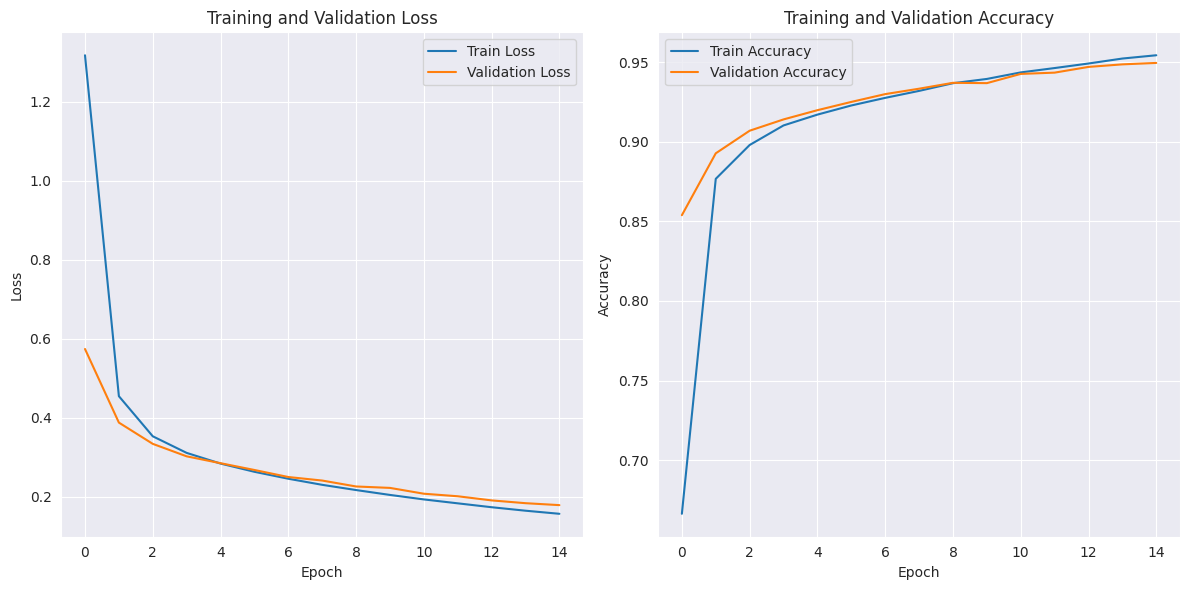

In [14]:
batch_sizes = [16, 32, 64,128]  # Different batch sizes to experiment with

for bs in batch_sizes:  
    train_loader = DataLoader(train_subset, batch_size=bs, shuffle=True)  # Update batch size for training
    val_loader = DataLoader(val_subset, batch_size=bs, shuffle=False)    # Update batch size for validation
    
    model = FeedforwardNN([28*28,128,64,10]).to(device)  # Initialize model
    print(f"\nTraining with Batch Size = {bs}")
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, 0.01,15)
    plot_results(train_losses, val_losses, train_accuracies, val_accuracies)
    results[bs] = {
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }


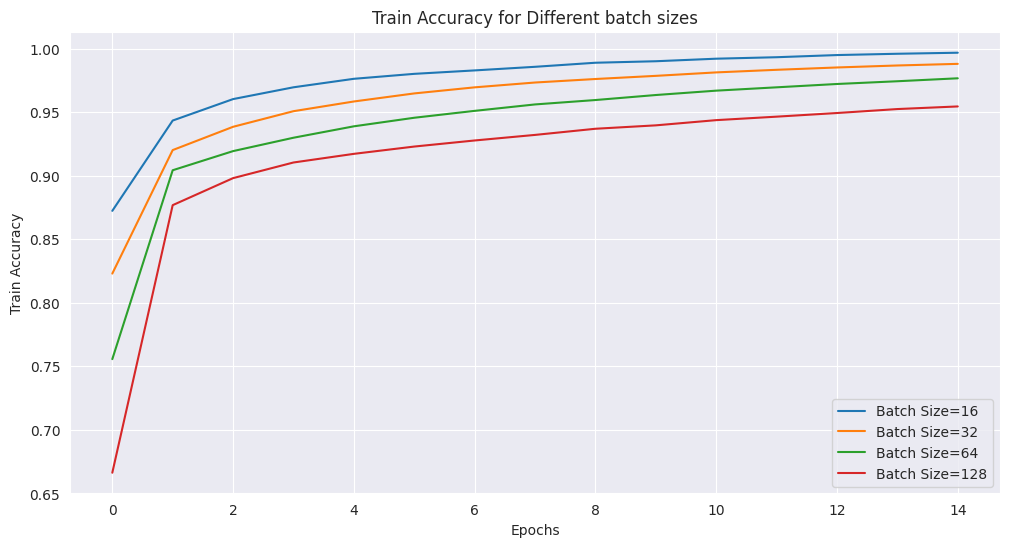

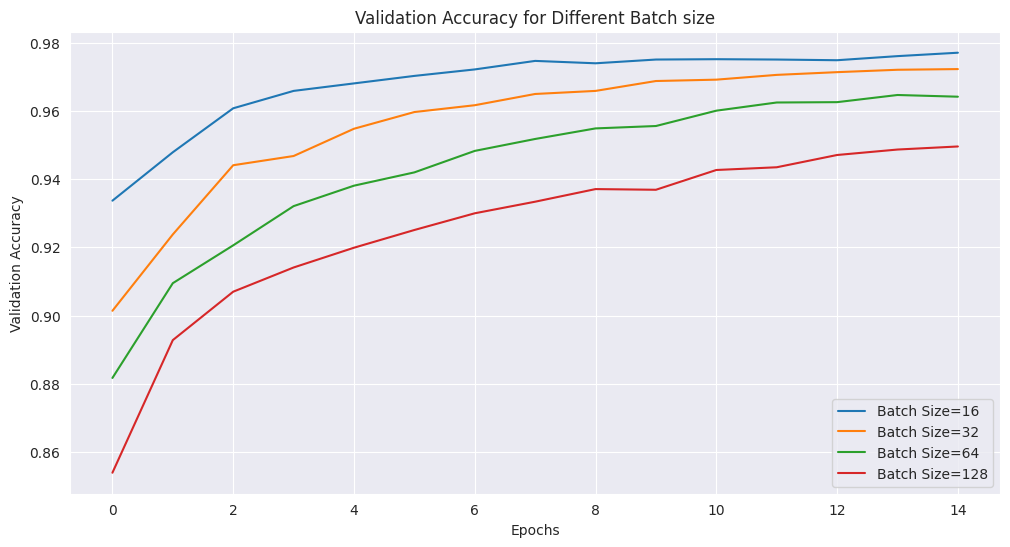

In [15]:
# Plot all learning rates on the same plot for train accuracies
plt.figure(figsize=(12, 6))
for bt in batch_sizes:
    plt.plot(results[bt]['train_accuracies'], label=f"Batch Size={bt}")
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy for Different batch sizes")
plt.legend()
plt.show()

# Plot all learning rates on the same plot for validation accuracies
plt.figure(figsize=(12, 6))
for bt in batch_sizes:
    plt.plot(results[bt]['val_accuracies'], label=f"Batch Size={bt}")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy for Different Batch size")
plt.legend()
plt.show()

# Insights on Batch Size Results

## Training with Batch Size = 16

- **Observations**:
  - Highest validation accuracy across all batch sizes.
  - Small gap between training accuracy (99.37%) and validation accuracy (97.67%) suggests slight overfitting.
  - Low validation loss (0.0774) indicates good generalization despite overfitting risk.

## Training with Batch Size = 32

- **Observations**:
  - Lower training accuracy compared to Batch Size = 16, but validation accuracy (96.98%) is close.
  - Smaller gap between training and validation accuracy, indicating reduced overfitting risk.
  - Slightly higher validation loss (0.1110) compared to Batch Size = 16.

## Training with Larger Batch Sizes (64, 128, 256)
- Validation accuracies and losses are significantly lower compared to Batch Sizes = 16 and 32.
- Training becomes less effective as batch size increases, leading to suboptimal results.

---

# Recommendation: Batch Size Selection
- **Batch Size = 16** achieves the highest validation accuracy (97.67%) but shows signs of slight overfitting.  
- **Batch Size = 32** provides a safer choice with marginally lower validation accuracy (96.98%) and less overfitting risk.  
- For a balance between performance and generalization, **Batch Size = 32 is the recommended choice**.


# Analyzing neurons/layers combinations


In [38]:
neurons = [64, 128, 256,512]
layers = [2, 3, 4, 5]
results = {}

for n in neurons:
    results[n]={}
    for l in layers:
        layer_configs=[28*28] 
        for i in range(0, l):
            layer_configs += [n//2**i]  
        layer_configs.append(10)
        print(layer_configs)
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)  # Update batch size for training
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)    # Update batch size for validation
        
        model = FeedforwardNN(layer_configs).to(device)  # Initialize model
        print(f"\nTraining with neuron = {n} layer = {l}")
        # Train the model with the current batch size
        train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader,0.01,15)
        results[n][l] = {
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }
        
        plot_results(train_losses, val_losses, train_accuracies, val_accuracies)

SyntaxError: invalid syntax (1943665000.py, line 25)

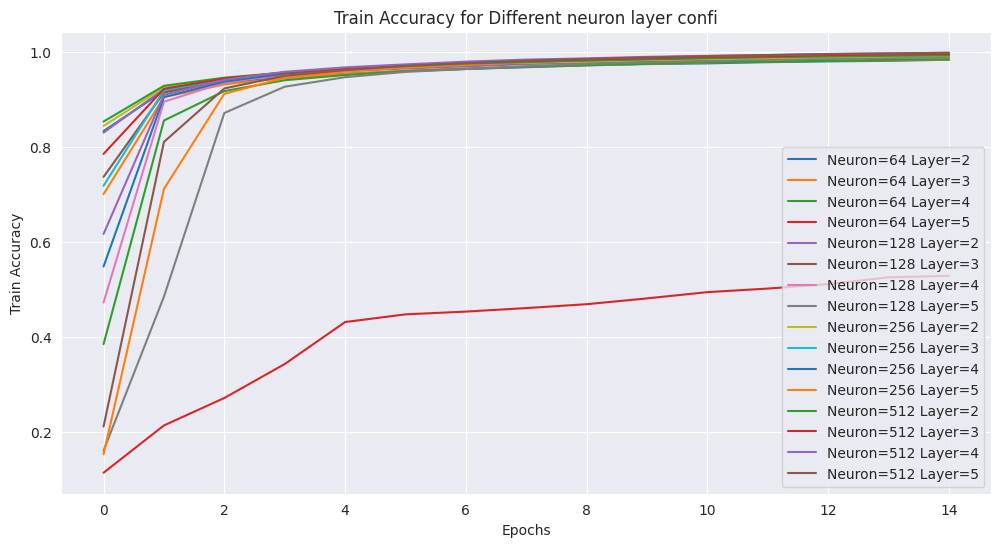

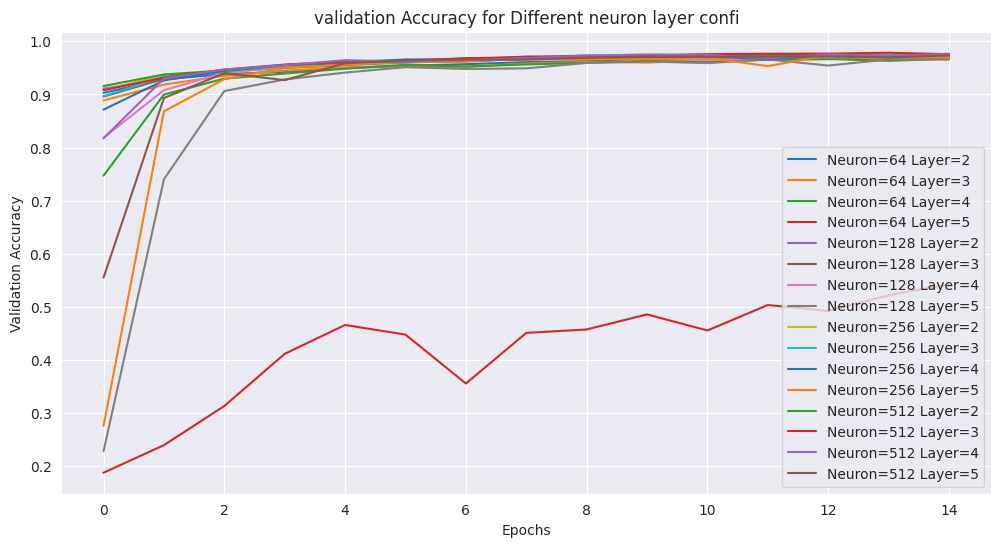

In [17]:
plt.figure(figsize=(12, 6))
for n in neurons:
    for l in layers:
        plt.plot(results[n][l]['train_accuracies'], label=f"Neuron={n} Layer={l}")
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy for Different neuron layer confi")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
for n in neurons:
    for l in layers:
        plt.plot(results[n][l]['val_accuracies'], label=f"Neuron={n} Layer={l}")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("validation Accuracy for Different neuron layer confi")
plt.legend()
plt.show()


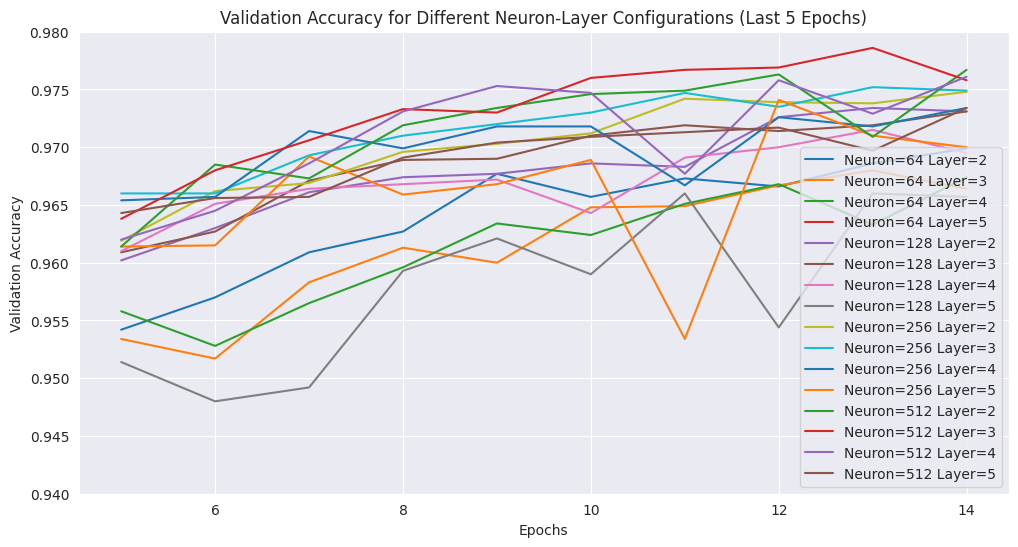

In [31]:
plt.figure(figsize=(12, 6))
for n in neurons:
    for l in layers:
        # Plot only the last 5 epochs
        plt.plot(range(len(results[n][l]['val_accuracies']) - 10, len(results[n][l]['val_accuracies'])), 
                 results[n][l]['val_accuracies'][-10:], 
                 label=f"Neuron={n} Layer={l}")

plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy for Different Neuron-Layer Configurations (Last 5 Epochs)")
plt.ylim(0.94, 0.98)  # Set y-axis range
plt.legend()
plt.show()


## Optimal Configuration
- **128 neurons with 2 layers** is the most efficient setup:
  - We found that this setup reaches a greate validation accuracy with correlates to the training accuracy
  - this configuration was also found to not fluctuate each epoch, which show stablity
  - V

## Observations
- Adding more layers or neurons beyond this led to **overfitting** with minimal accuracy improvement.
- Models with **5 layers** or **512 neurons** showed higher training accuracy but increased the instability



Epoch [1/15], Train Loss: 0.6148, Train Accuracy: 0.8339, Val Loss: 0.3106, Val Accuracy: 0.9115
Epoch [2/15], Train Loss: 0.2657, Train Accuracy: 0.9227, Val Loss: 0.2465, Val Accuracy: 0.9273
Epoch [3/15], Train Loss: 0.2068, Train Accuracy: 0.9391, Val Loss: 0.1987, Val Accuracy: 0.9423
Epoch [4/15], Train Loss: 0.1672, Train Accuracy: 0.9508, Val Loss: 0.1734, Val Accuracy: 0.9505
Epoch [5/15], Train Loss: 0.1394, Train Accuracy: 0.9595, Val Loss: 0.1512, Val Accuracy: 0.9566
Epoch [6/15], Train Loss: 0.1187, Train Accuracy: 0.9659, Val Loss: 0.1412, Val Accuracy: 0.9597
Epoch [7/15], Train Loss: 0.1029, Train Accuracy: 0.9703, Val Loss: 0.1272, Val Accuracy: 0.9634
Epoch [8/15], Train Loss: 0.0902, Train Accuracy: 0.9742, Val Loss: 0.1189, Val Accuracy: 0.9658
Epoch [9/15], Train Loss: 0.0806, Train Accuracy: 0.9768, Val Loss: 0.1110, Val Accuracy: 0.9688
Epoch [10/15], Train Loss: 0.0717, Train Accuracy: 0.9796, Val Loss: 0.1072, Val Accuracy: 0.9691
Epoch [11/15], Train Loss: 0.

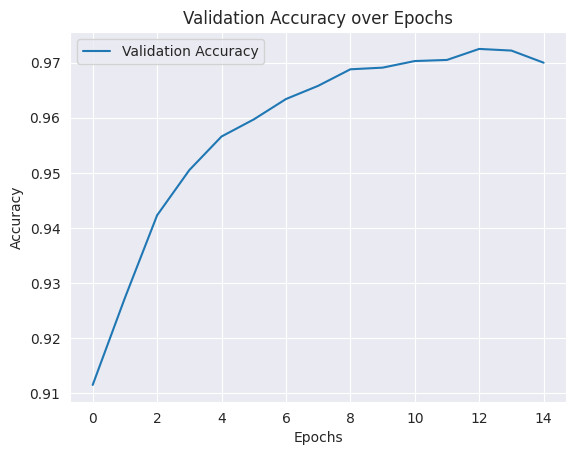

In [18]:
batch = 32
train_ld = DataLoader(train_subset, batch_size=batch, shuffle=True)
val_ld = DataLoader(val_subset, batch_size=batch)
test_ld = DataLoader(test_dataset, batch_size=batch)

final_model = FeedforwardNN([28*28, 128, 64, 10]).to(device)

learning_rate = 0.01
train_losses, val_losses, train_accuracies, val_accuracies = train_model(final_model, train_ld, val_ld, learning_rate, 15)
plt.plot( val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.legend()
plt.show()


torch.Size([1, 1, 28, 28])
[3.5094476e-07 4.6345939e-08 5.0494947e-07 2.0571063e-08 3.5671976e-06
 1.8314213e-06 9.9999285e-01 1.0308156e-11 8.7129126e-07 1.2112022e-10]


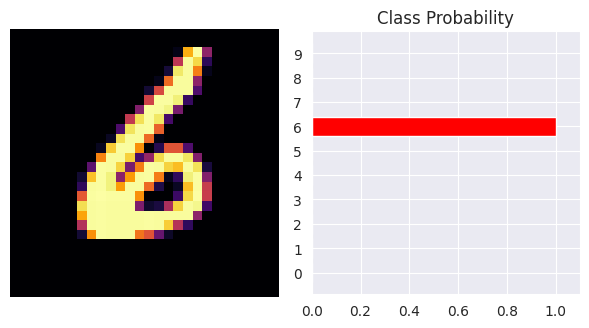

In [37]:
import numpy as np
img = images[0]
img = img.to(device)
img = img.view(-1, 1, 28, 28)
print(img.shape)

# Since we want to use the already pretrained weights to make some prediction
# we are turning off the gradients
with torch.no_grad():
    logits = final_model.forward(img)

# We take the softmax for probabilites since our outputs are logits
probabilities = F.softmax(logits, dim=1).detach().cpu().numpy().squeeze()

print(probabilities)

fig, (ax1, ax2) = plt.subplots(figsize=(6,8), ncols=2)
ax1.imshow(img.view(1, 28, 28).detach().cpu().numpy().squeeze(), cmap='inferno')
ax1.axis('off')
ax2.barh(np.arange(10), probabilities, color='r' )
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)

plt.tight_layout()

# Fianl Model Test accuracy and confusion matrix

Test Accuracy: 97.34%


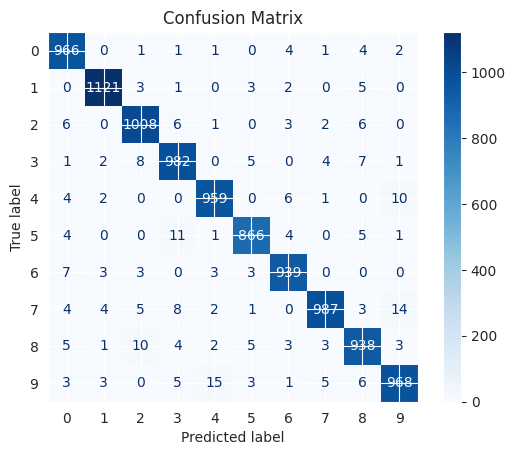

In [20]:
final_model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        preds = y_pred.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

accuracy = correct / total

print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Plot confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## Updating to CNN Model with A Dropout and Normalizaition layers


In [32]:


class CNNWithDropoutAndLayerNorm(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(CNNWithDropoutAndLayerNorm, self).__init__()

        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(32)
       

        # Convolutional layer 1
        # self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1)
        # self.layernorm1 = nn.LayerNorm([32, 28, 28])  # This assumes input image is 28x28
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)  # Pooling reduces size to 14x14
        self.dropout1 = nn.Dropout(0.25)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(64)
        # Convolutional layer 2
        # self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # self.layernorm2 = nn.LayerNorm([64, 14, 14])  # Shape after first pooling
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)  # Pooling reduces size to 7x7
        self.dropout2 = nn.Dropout(0.25)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # After pooling, the feature map is 7x7
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = x.view(x.size(0), 1, 28, 28)  # Assuming MNIST dataset
    
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        # Flatten for the fully connected layers
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        x = self.fc2(x)

        return x


# Training the CNN model 

In [33]:
def train_model_cnn(model, train_loader, val_loader, criterion, optimizer, epochs=10, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)

        val_loss = running_loss / len(val_loader)
        val_accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss {train_loss:.4f}, Train Acc {train_accuracy:.4f}, Val Loss {val_loss:.4f}, Val Acc {val_accuracy:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies


## Running the model


CNN data preparation complete.
Epoch 1/10: Train Loss 0.3365, Train Acc 0.8934, Val Loss 0.0646, Val Acc 0.9808
Epoch 2/10: Train Loss 0.1650, Train Acc 0.9507, Val Loss 0.0524, Val Acc 0.9844
Epoch 3/10: Train Loss 0.1362, Train Acc 0.9590, Val Loss 0.0501, Val Acc 0.9853
Epoch 4/10: Train Loss 0.1134, Train Acc 0.9662, Val Loss 0.0435, Val Acc 0.9879
Epoch 5/10: Train Loss 0.0994, Train Acc 0.9692, Val Loss 0.0413, Val Acc 0.9878
Epoch 6/10: Train Loss 0.0878, Train Acc 0.9726, Val Loss 0.0365, Val Acc 0.9893
Epoch 7/10: Train Loss 0.0798, Train Acc 0.9752, Val Loss 0.0374, Val Acc 0.9896
Epoch 8/10: Train Loss 0.0713, Train Acc 0.9778, Val Loss 0.0357, Val Acc 0.9901
Epoch 9/10: Train Loss 0.0655, Train Acc 0.9802, Val Loss 0.0325, Val Acc 0.9906
Epoch 10/10: Train Loss 0.0609, Train Acc 0.9815, Val Loss 0.0341, Val Acc 0.9908


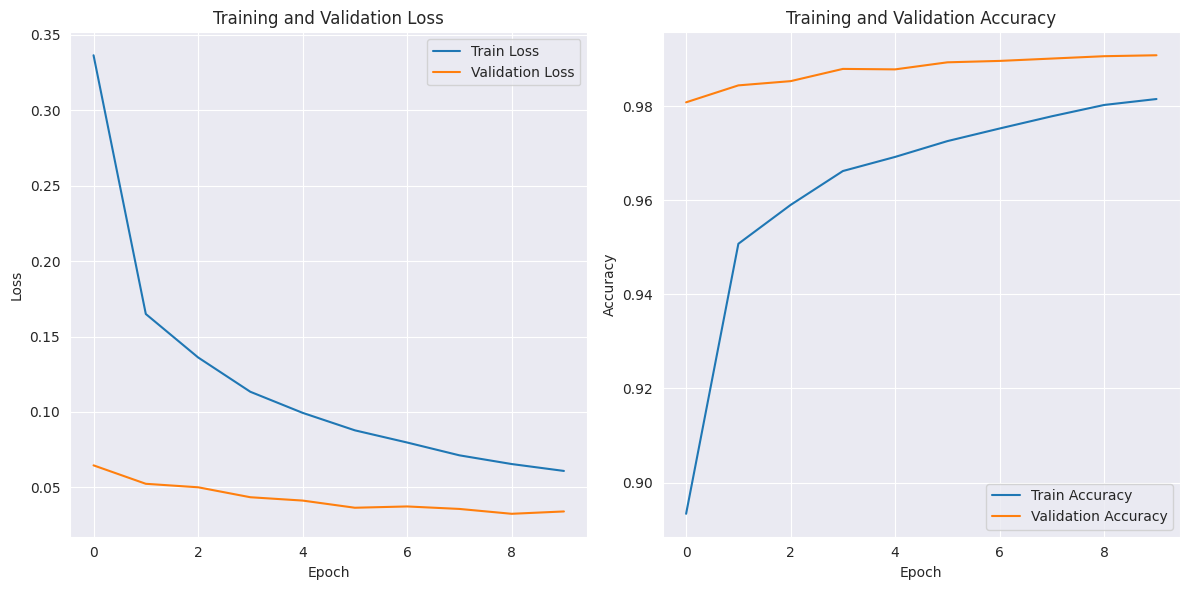

In [34]:
input_channels = 1  # Assuming grayscale images (e.g., MNIST)
num_classes = 10

# Create DataLoader instances for batch processing
train_loader_cnn = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader_cnn = DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader_cnn = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("CNN data preparation complete.")

model = CNNWithDropoutAndLayerNorm(input_channels, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train model
train_losses, val_losses, train_accuracies, val_accuracies = train_model_cnn(
    model, train_loader, val_loader, criterion, optimizer
)

# Plot metrics
plot_results(train_losses, val_losses, train_accuracies, val_accuracies)


# CNN model evaluation

In [35]:
def evaluate_model_cnn(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    # Set model to evaluation mode
    model.eval()
    model.to(device)
    
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            # Move data to device
            X_batch = X_batch.view(-1, 1, 28, 28)  # Reshape to [batch_size, channels, height, width]
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)

            # Collect predictions and true labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

            # Update accuracy metrics
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

    # Calculate accuracy
    accuracy = correct / total

    # Confusion Matrix and Classification Report
    cm = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names=[str(i) for i in range(10)])  # Assuming MNIST (digits 0-9)

    return accuracy, cm, class_report


## Report on Accuracy and Confusion Matrix for CNN


Test Accuracy: 0.9927

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       1.00      0.99      1.00      1135
           2       0.99      1.00      0.99      1032
           3       1.00      0.99      1.00      1010
           4       0.99      0.99      0.99       982
           5       0.98      1.00      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



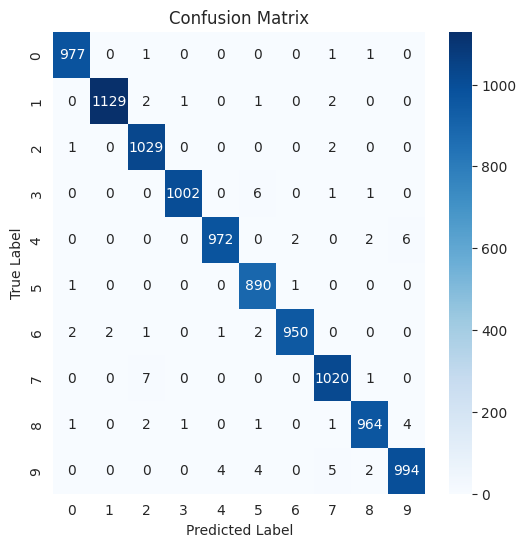

In [36]:
# Evaluate the model on the test dataset
accuracy, cm, class_report = evaluate_model_cnn(model, test_loader)

# Print Accuracy and Classification Report
print(f"Test Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(class_report)

# Plot Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Key Insights: 

- **Improved Accuracy**: The CNN model outperforms feedforward neural networks, achieving higher validation accuracy per epoch due to its ability to capture spatial features in the MNIST dataset.  
- **Faster Convergence**: CNNs reach high accuracy in fewer epochs compared to traditional neural networks, highlighting their efficiency for image-related tasks.  
- **Feature Extraction**: Convolutional layers effectively extract local patterns (e.g., edges and shapes), enhancing digit classification performance.  
- **Regularization Effects**: Dropout and pooling layers in CNNs help prevent overfitting, leading to better generalization on validation data.  
- **Best Choice for MNIST**: CNNs are well-suited for the MNIST dataset, as their architecture aligns with the spatial structure of the data, providing a significant performance boost over fully connected layers.